# Gathering Informations

### Imports

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Science & Machine Learning
import cv2
import numpy as np
import pandas as pd
import skimage.feature
import imageutils as iu

# System directories
from os import listdir
from os.path import isfile, join
from os import environ as env

# Private image processing utils
from imageutils import *

# Multiprocessing
from multiprocessing import Pool

# ProgressBar
from tqdm import tqdm, tqdm_notebook

# ProgressBar
import time
from tqdm import *
import json, glob, numba
import collections

__Constants__

In [2]:
DATASET_ROOT_PATH = env['STORAGE_PATH']
TRAIN_PATH = join(DATASET_ROOT_PATH, 'Train')
TEST_PATH = join(DATASET_ROOT_PATH, 'Test')
COORDS_PATH = join(DATASET_ROOT_PATH, 'Coords')

# Tableau colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

colors = ['#%02x%02x%02x' % color for color in tableau20]

CLASSES = collections.OrderedDict(sorted({'adult_males' : (255,0,0), 'subadult_males' : (244,8,242), 'adult_females' : (87,46,10), 'juveniles' : (0,0,255), 'pups': (0,255,0)}.items()))

### Set of train dataset

In [ ]:
images_set = {int(f[:-4]) : join(TRAIN_PATH, f) for f in listdir(TRAIN_PATH) if f.endswith("jpg")}

### Set of corresponding coordinates

In [ ]:
coords_set = {int(f.partition('.')[0]) : join(COORDS_PATH, f) for f in listdir(COORDS_PATH) if f.endswith('.csv')}

### Merge dictionaries

In [ ]:
sets = [images_set, coords_set]
dataset = {}

for entry in images_set.items():
    dataset [ entry[0] ] = tuple( [ entry [0] , images_set [ entry [0] ] , coords_set [ entry [0] ]] )

dataset = collections.OrderedDict(sorted(dataset.items()))

### Set of test images

In [3]:
test_set = {int(f[:-4]) : join(TEST_PATH, f) for f in listdir(TEST_PATH) if f.endswith("jpg")}

In [ ]:
print(test_set)

### Plot resolutions and ratios histogram

__Compute resolutions__

In [4]:
resolutions = {}
ratios = {}

for path in tqdm(test_set.values()):
    # Read image
    img = cv2.imread(path)
    
    # Get resolution
    try:
        res = str(iu.resolution(img))
    except TypeError:
        print("Error with %s" % (path))
    if res not in resolutions:
        resolutions[res] = 1
    else:
        resolutions[res] += 1

 36%|███▌      | 6653/18636 [1:02:54<1:44:19,  1.91it/s]

Error with /mnt/storage/users/z1126942/Test/6653.jpg
Error with /mnt/storage/users/z1126942/Test/6654.jpg
Error with /mnt/storage/users/z1126942/Test/6655.jpg


100%|██████████| 18636/18636 [2:58:11<00:00,  1.62it/s]


In [ ]:
resolutions = {}
ratios = {}

for id, path, coords_path in tqdm(dataset.values()):
    # Read image
    img = cv2.imread(path)
    
    # Get resolution
    res = str(iu.resolution(img))
    if res not in resolutions:
        resolutions[res] = 1
    else:
        resolutions[res] += 1
    
    # Get ratio
    ratio_str = iu.ratio(img)
    if ratio_str not in ratios:
        ratios[ratio_str] = 1
    else:
        ratios[ratio_str] += 1

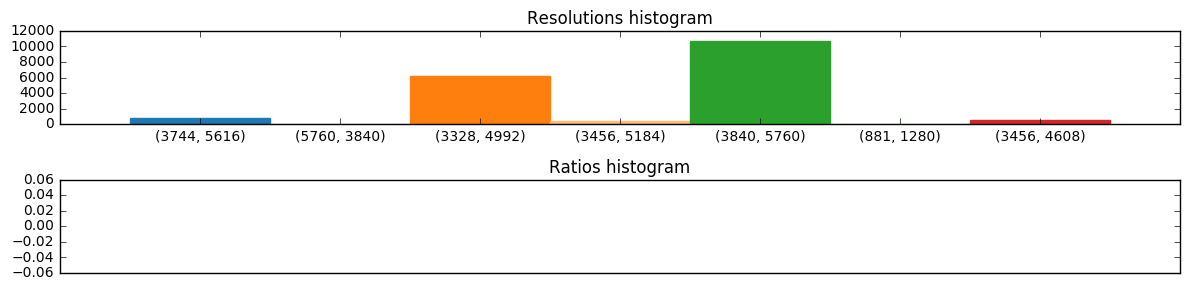

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 3))

axes[0].set_title('Resolutions histogram')
axes[1].set_title('Ratios histogram')

plt.sca(axes[0])
bars1 = plt.bar(range(len(resolutions)), resolutions.values(), align='center', width=1)
plt.xticks(range(len(resolutions)), resolutions.keys())
for rank in range(0, len(bars1)):
    bars1[rank].set_color(colors[rank])

plt.sca(axes[1])
bars2 = plt.bar(range(len(ratios)), ratios.values(), align='center', width=1)
plt.xticks(range(len(ratios)), ratios.keys())
for rank in range(0, len(bars2)):
    bars2[rank].set_color(colors[6 + rank])

fig.tight_layout()
plt.show()

## Resize

In [ ]:
it = 0
for img_path in tqdm(test_set.values()):
    if it < 5772:
        it += 1
        continue
    
    # Read image
    try:
        im = bgr2rgb(cv2.imread(img_path))
    except ValueError:
        print(img_path)
    except TypeError:
        print(img_path)
    
    # Choose only bigger resolutions
    if resolution(im) == (3744, 5616):
        #print(id)

        # Resize image
        resized = cv2.resize(im, None, fx=8/9, fy=8/9, interpolation = cv2.INTER_CUBIC)

        # Save image
        cv2.imwrite(img_path, rgb2bgr(resized))
        #cv2.imwrite('dataset/Data/Resized/Train/' + str(id) + '.jpg', rgb2bgr(resized))
        
        continue
        
        # Read coordinates
        with open(dataset[id][2]) as coords_file:
            coords = json.load(coords_file)

        count_dict = { 'adult_males' : [],
                       'subadult_males' : [],
                       'adult_females' : [],
                       'juveniles' : [],
                       'pups' : []}

        # Resize coordinates
        for classname, color in CLASSES.items():
            for y, x in coords[classname]:
                count_dict[classname].append((int(y*8.0/9.0), int(x*8.0/9.0)))

        # Convert to JSON
        obj = json.dumps({
                'adult_males':   count_dict['adult_males'],
                'subadult_males':count_dict['subadult_males'],
                'adult_females': count_dict['adult_females'],
                'juveniles':     count_dict['juveniles'],
                'pups':          count_dict['pups'],
                'counts':        [len(count_dict['adult_males']), len(count_dict['subadult_males']), len(count_dict['adult_females']), len(count_dict['juveniles']), len(count_dict['pups'])],
                    'id': str(id)
            }, separators=(',',':'))

        # Save coordinates
        with open('dataset/Data/Resized/Coords/' + str(id) + '.csv', 'w') as f:
                f.write(obj)